In [13]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

Load file pkl

In [14]:
with open("S:/Uni_stuff/Semester_7/Ilmu_Data_2/Proyek/Tennis-Analysis-YOLO-PyTorch-main - ipynb/tracker_stubs/ball_detections_yu2_new.pkl", 'rb') as f:
    ball_detections = pickle.load(f)

In [15]:
ball_detections

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {1: [628.5178833007812,
   519.3511352539062,
   646.0828247070312,
   537.47509765625]},
 {},
 {1: [537.2266845703125,
   537.5086669921875,
   560.7222290039062,
   562.7865600585938]},
 {1: [489.5065612792969,
   556.8919067382812,
   513.308349609375,
   580.1825561523438]},
 {1: [489.53594970703125,
   556.9307250976562,
   513.2557983398438,
   580.1607666015625]},
 {},
 {},
 {1: [339.04412841796875,
   629.08544921875,
   371.73724365234375,
   661.6373901367188]},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {1: [675.7901000976562,
   64.33934783935547,
   687.0084228515625,
   76.181396484375]},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {1: [795.917236328125, 57.90591812133789, 809.7499389648438, 73.98779296875]},
 {1: [795.9252319335938,
   57.

# interpolate

Kode ini mengolah data posisi bola yang terdeteksi untuk mengisi nilai yang hilang (missing values) dengan interpolasi agar data lebih lengkap dan dapat digunakan untuk analisis lebih lanjut.

In [16]:
ball_positions = [x.get(1, []) for x in ball_detections]
# convert list to pandas df to interpolate the missing vals
df_ball_positions = pd.DataFrame(ball_positions, columns=['x1', 'y1', 'x2', 'y2'])

# interpolate missing vals
df_ball_positions = df_ball_positions.interpolate()
# since default direction is forward, we need to fill the 1st row
df_ball_positions = df_ball_positions.bfill()

df_ball_positions

,x1,y1,x2,y2
0,628.517883,519.351135,646.082825,537.475098
1,628.517883,519.351135,646.082825,537.475098
2,628.517883,519.351135,646.082825,537.475098
3,628.517883,519.351135,646.082825,537.475098
4,628.517883,519.351135,646.082825,537.475098
...,...,...,...,...
605,714.384094,893.801697,734.642578,915.745789
606,710.410095,931.657654,731.529419,954.985840
607,706.436096,969.513611,728.416260,994.225891
608,706.434509,969.514709,728.416504,994.231750


Kode ini melanjutkan pemrosesan data posisi bola untuk mendapatkan deteksi yang lebih halus dan mengurangi pengaruh outlier.

In [17]:
# get smooth detections in all frames
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
# reduce the effect of outliers
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

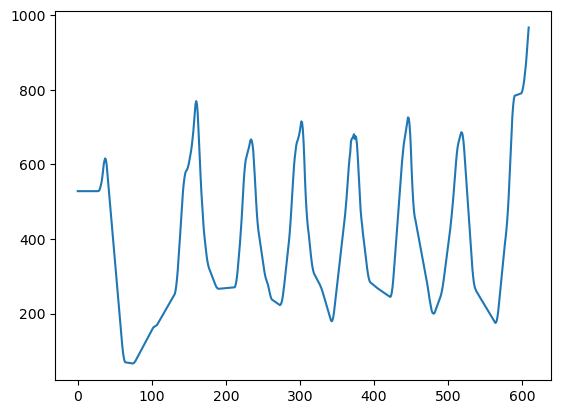

In [18]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

obs: ball changes y-direction once it is hit by a player

Kode ini membuat Kolom delta_y yang memberikan informasi tentang seberapa banyak posisi bola bergerak secara vertikal antara dua frame berturut-turut.

In [19]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()  # subtracts 2 consecutive rows from each other

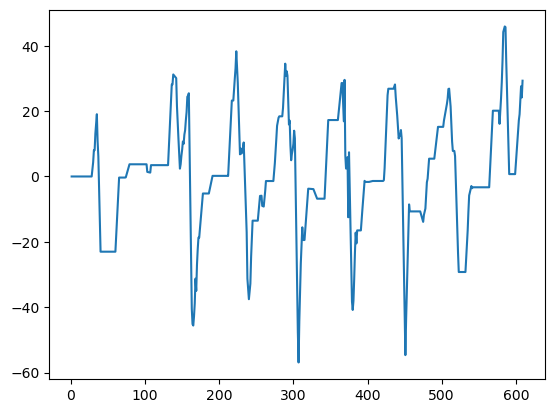

In [20]:
plt.plot(df_ball_positions['delta_y'])

# ball hit

- Kode ini mendeteksi pergerakan bola yang signifikan, yang diindikasikan dengan pergerakan vertikal yang konsisten dalam satu arah untuk sejumlah frame berturut-turut (minimal 25 frame).
- Setiap kali deteksi ini terjadi, kode memberi label 1 pada kolom ball_hit untuk menandakan bahwa bola telah dipukul atau mengalami perubahan besar dalam gerakan.

In [21]:
# init a new col to track frames where ball is hit
df_ball_positions['ball_hit'] = 0

In [ ]:
# Set minimum jumlah frame berturut-turut yang harus menunjukkan pergerakan dalam satu arah untuk dianggap sebagai "hit"
min_change_frames_for_hit = 25

# Loop untuk iterasi dari frame ke-1 hingga frame ke-(n - min_change_frames_for_hit * 1.2)
# Ini untuk memeriksa pergerakan bola dalam setiap frame berturut-turut
for i in range(1, len(df_ball_positions) - int(min_change_frames_for_hit*1.2)):
    negative_pos_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i+1] < 0  # Mengecek apakah ada perubahan arah pergerakan bola dari naik (positif) ke turun (negatif)
    positive_pos_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i+1] > 0  # Mengecek apakah ada perubahan arah pergerakan bola dari turun (negatif) ke naik (positif)

    # Jika ada perubahan arah (baik negatif atau positif), lanjutkan untuk menghitung berapa banyak perubahan tersebut terjadi
    if negative_pos_change or positive_pos_change:
        pos_change_count = 0 # Inisialisasi penghitung jumlah perubahan arah yang valid dalam satu arah
        for nxt_frame_idx in range(i+1, i + int(min_change_frames_for_hit * 1.2) + 1):  # Loop untuk memeriksa pergerakan bola dalam frame berikutnya, dari frame i+1 sampai frame i + min_change_frames_for_hit yang ditambah dengan margin
            negative_pos_change_nxt_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[nxt_frame_idx] < 0 # Mengecek apakah perubahan arah tetap negatif (terus bergerak turun)
            positive_pos_change_nxt_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[nxt_frame_idx] > 0 # Mengecek apakah perubahan arah tetap positif (terus bergerak naik)

            if negative_pos_change and negative_pos_change_nxt_frame: # Jika arah pergerakan bola terus negatif, tambahkan ke penghitung
                pos_change_count += 1 # Jika arah pergerakan bola terus positif, tambahkan ke penghitung
            elif positive_pos_change and positive_pos_change_nxt_frame:
                pos_change_count += 1

        # Jika ada lebih dari atau sama dengan min_change_frames_for_hit perubahan dalam satu arah, tandai sebagai "ball hit"
        if pos_change_count > min_change_frames_for_hit - 1:
            df_ball_positions['ball_hit'].iloc[i] = 1 # Set kolom 'ball_hit' pada baris i menjadi 1, yang menunjukkan bola telah "terpukul"

df_ball_positions[df_ball_positions['ball_hit'] == 1] # Menampilkan semua baris di df_ball_positions yang memiliki kolom 'ball_hit' bernilai 1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5536\1471192829.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5536\1471192829.py:20: SettingWithCopyWarnin

In [23]:
df_ball_positions[df_ball_positions['ball_hit'] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
37,365.983806,583.905761,396.958938,614.800911,599.353336,616.195860,6.161518,1
74,795.925232,57.907997,809.774963,73.995071,65.951534,66.345962,-0.264511,1
160,532.278503,742.134628,551.814209,763.447235,752.790932,769.850703,8.469313,1
190,1045.489556,259.756128,1058.909766,274.027505,266.891816,266.513352,-0.889875,1
234,645.069427,651.071335,664.989197,673.117004,662.094170,667.150586,3.542667,1
273,1109.438965,214.161118,1119.740845,225.939194,220.050156,222.831467,-1.390656,1
302,1177.104126,725.738892,1195.298584,746.110291,735.924591,715.495972,11.688568,1
343,700.701019,178.934079,712.479950,191.416562,185.175321,179.515999,-1.981172,1
373,609.863464,668.625549,627.046875,688.034546,678.330048,681.139856,5.912677,1
375,605.706787,682.616943,621.704895,699.737854,691.177399,676.066895,7.402087,1


In [24]:
ball_hit_frames_idx = df_ball_positions[df_ball_positions['ball_hit'] == 1].index.tolist()
ball_hit_frames_idx

[37, 74, 160, 190, 234, 273, 302, 343, 373, 375, 446, 481, 518, 564]